In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import dill
import re

from tqdm import tqdm
from itertools import chain
from sklearn.manifold import TSNE
from collections import defaultdict, Counter

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

from f723.tools.show.classification import plot_precision_recall_curve
from f723.tools.models.application import ClassificationResult

In [2]:
DATASET_DIR = '/home/mikhail/bioinformatics/data/dataset_all_60'
FEATURES_PATH = os.path.join(DATASET_DIR, 'features.npy')
TARGET_PATH = os.path.join(DATASET_DIR, 'target.npy')
GROUPS_PATH = os.path.join(DATASET_DIR, 'groups.npy')
FEATURES_SHAPE = (6830702, 465)

In [3]:
with open('description.pickle', 'rb') as infile:
    description = np.array(pickle.load(infile))

dm = {descr: i for i, descr in enumerate(description)}
    
with open('/home/mikhail/bioinformatics/data/nonredundant.txt', 'r') as infile:
    nonredundant_chain_ids = infile.read().splitlines()

In [4]:
def get_batch(index):
    with open(os.path.join(DATASET_DIR, 'batch_{}'.format(index)), 'rb') as infile:
        return dill.load(infile)
    

def get_data():
    return chain.from_iterable((get_batch(i) for i in tqdm(range(30))))

In [5]:
chain_ids = ['{}.cif1_{}'.format(sample.meta.pdb_id, sample.meta.pair.nt_left.chain_id) 
             for sample in get_data()]

nonredundant_mask = np.repeat([chain_id in nonredundant_chain_ids for chain_id in chain_ids], 2)

100%|██████████| 30/30 [01:42<00:00,  3.43s/it]


In [6]:
def load_features():
    features = np.memmap(FEATURES_PATH, shape=FEATURES_SHAPE)
    target = np.load(TARGET_PATH)
    pdb_ids = np.load(GROUPS_PATH)
    
    return features, target, pdb_ids

In [7]:
features, target, pdb_ids = load_features()

In [8]:
mask = (target != 0) & nonredundant_mask & (features[:, dm[('relation', 'LR')]] == 1)

features = features[mask]
target = target[mask] == 1
pdb_ids = pdb_ids[mask]

In [9]:
features.shape[0], np.sum(target)

(1130986, 418)

Можно видеть, что LR-пары в датасете редкость

In [10]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(features, target, pdb_ids)

feature_importances = []
target_pred = np.zeros_like(target)
pred_proba = np.zeros_like(target, dtype=np.float32)

for train_index, test_index in group_kfold.split(features, target, pdb_ids):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    feature_importances.append(model.feature_importances_)
    target_pred[test_index] = y_pred
    pred_proba[test_index] = model.predict_proba(X_test)[:, 1]
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.0005149499481770116, test positive rate: 0.00019953263317843973


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.99980047, 0.        ]), array([1., 0.]), array([0.99990022, 0.        ]), array([521114,    104]))
Train positive rate: 0.0004044545404177517, test positive rate: 0.000308048877088498


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.99969195, 0.        ]), array([1., 0.]), array([0.99984595, 0.        ]), array([408900,    126]))
Train positive rate: 0.00033832615016794135, test positive rate: 0.0008666547128085589


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.99913335, 0.        ]), array([1., 0.]), array([0.99956648, 0.        ]), array([66866,    58]))
Train positive rate: 0.00035152556455569613, test positive rate: 0.0006562071228300424


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.99934379, 0.        ]), array([1., 0.]), array([0.99967179, 0.        ]), array([67008,    44]))
Train positive rate: 0.00031196557102854675, test positive rate: 0.0012880807596680945
(array([0.99871192, 0.        ]), array([1., 0.]), array([0.99935554, 0.        ]), array([66680,    86]))


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision_recall_fscore_support


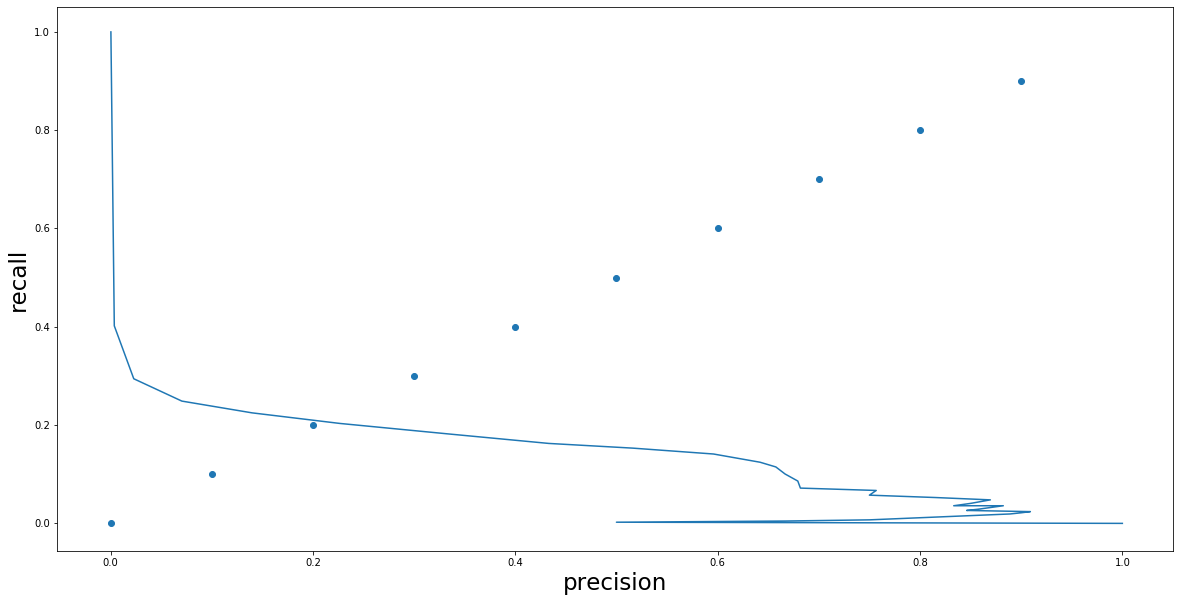

In [11]:
plt.figure(figsize=(20, 10))

plot_precision_recall_curve(ClassificationResult(
    target=target, 
    predicted=target_pred, 
    predicted_proba=pred_proba));

In [12]:
precision, recall, thresholds = precision_recall_curve(target == 1, pred_proba)

In [13]:
index = np.argmin(np.abs(precision - 0.2))
threshold = thresholds[index]

precision[index], recall[index]

(0.22666666666666666, 0.20334928229665072)

In [14]:
shifted_target_pred = pred_proba > threshold

In [15]:
lw_types = np.repeat(np.load(os.path.join(DATASET_DIR, 'lw.npy')), 2)[mask]

regex = re.compile('[ct][SWH]{2}')
symmetric_keys = {}
cis_trans_keys = {}

for key in set(lw_types):
    if regex.match(key):
        bond = ''.join(sorted(key[1:]))
        symmetric_keys[key] = key[0] + bond
        cis_trans_keys[key] = bond
        
symmetric_lw_types = np.array([symmetric_keys.get(lwt, 'NO') for lwt in lw_types])

In [16]:
tp = target & shifted_target_pred
fn = target & ~shifted_target_pred

keys = list(set(symmetric_lw_types))
true_positive_counter = Counter(symmetric_lw_types[tp])
false_negative_counter = Counter(symmetric_lw_types[fn])

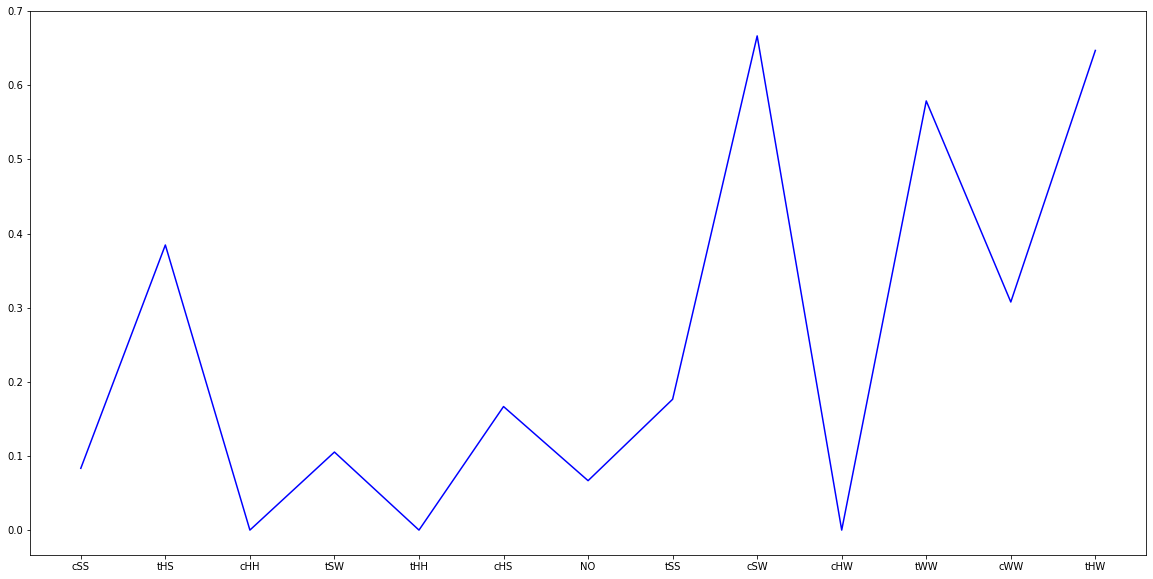

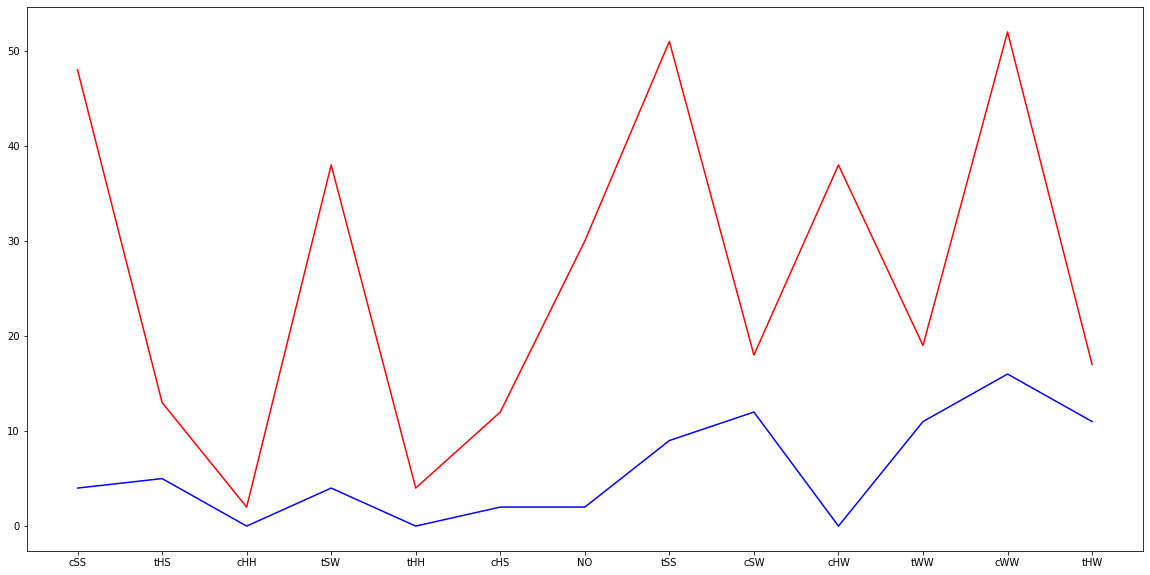

In [17]:
xs = np.arange(len(keys))
true_positive_num = np.array([true_positive_counter[k] for k in keys])
false_negative_num = np.array([false_negative_counter[k] for k in keys])

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, true_positive_num / false_negative_num, c='b')

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, true_positive_num, c='b')
plt.plot(xs, false_negative_num, c='r')

In [18]:
features_index, features_description = zip(*[(i, item) for i, item in enumerate(description) 
                                             if (item[1] == 0) 
                                             or item[0] == 'relation'])




Stats for key: cSS


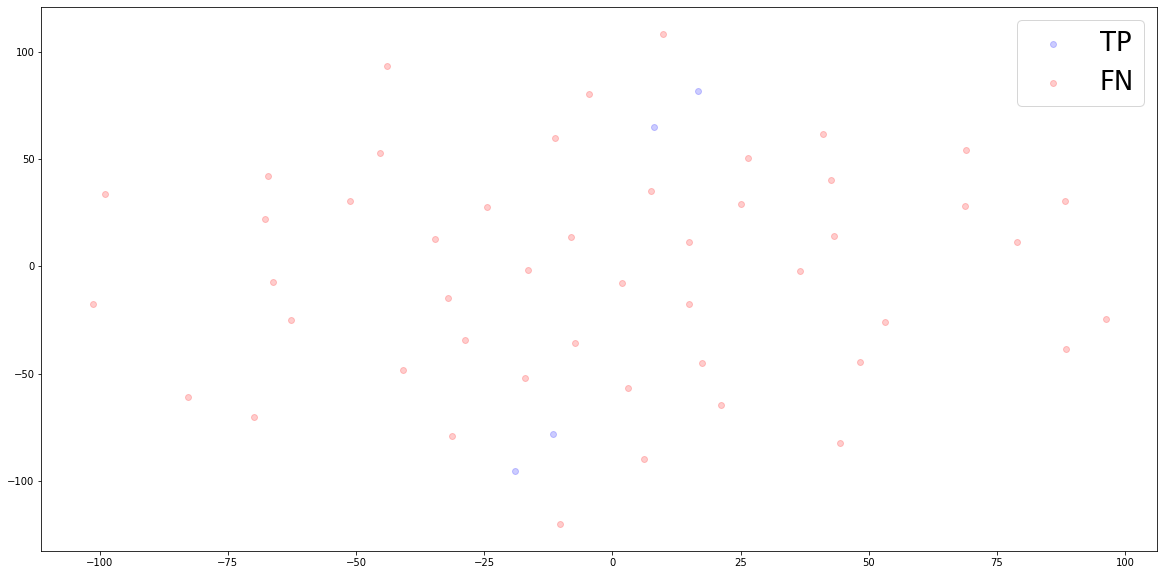




Stats for key: tHS


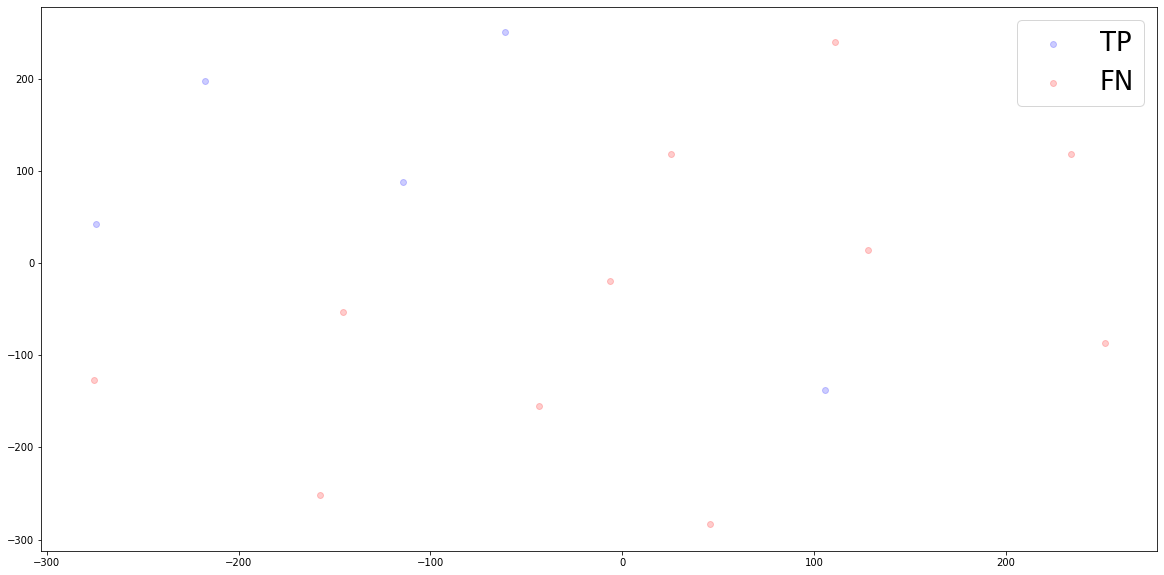




Stats for key: cHH


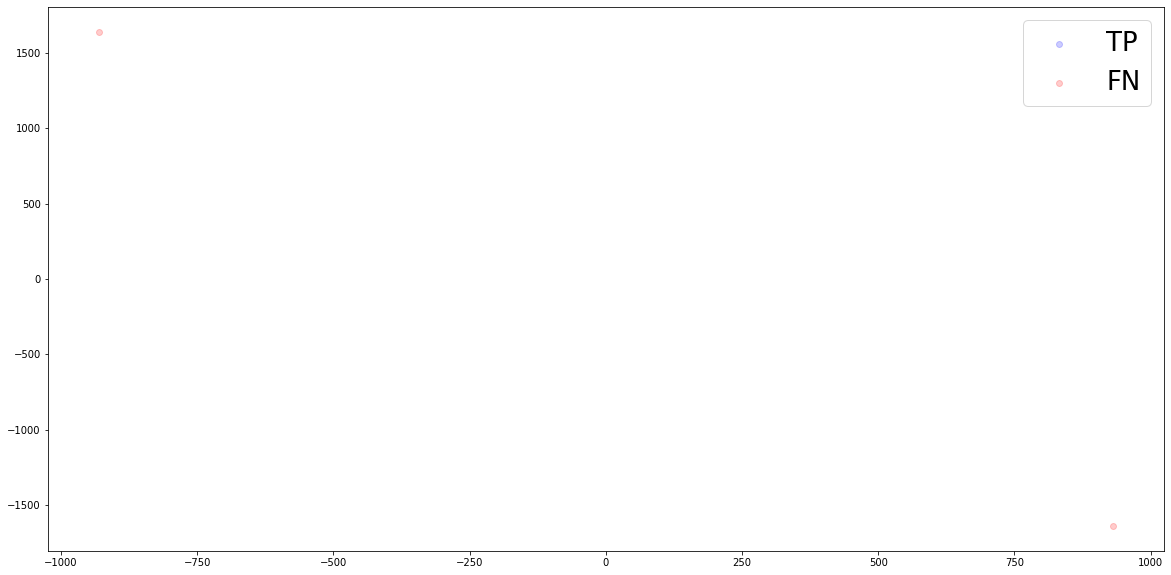




Stats for key: tSW


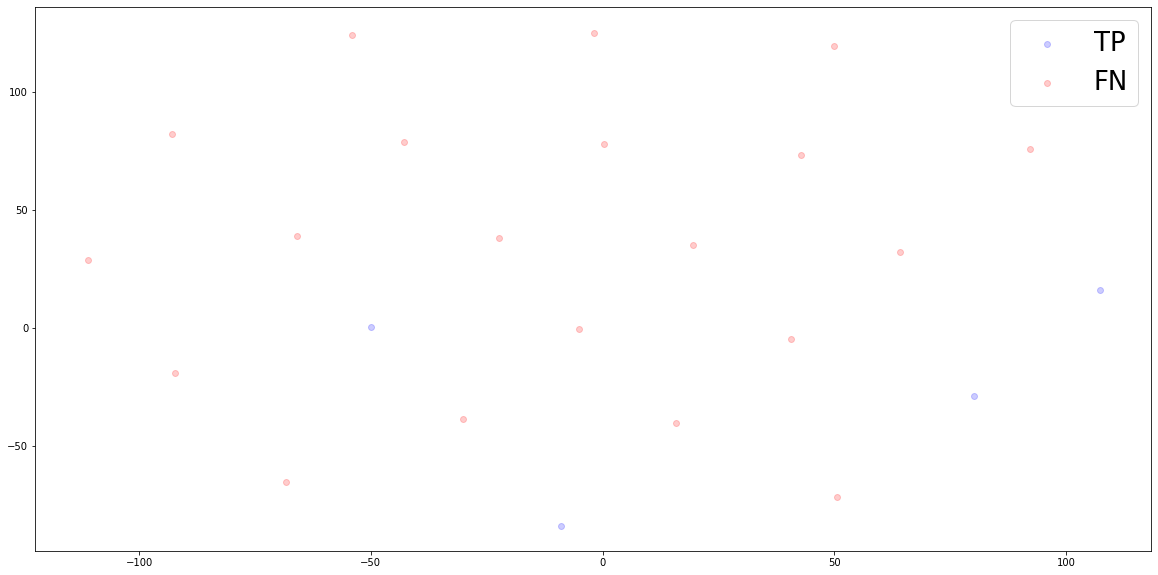




Stats for key: tHH


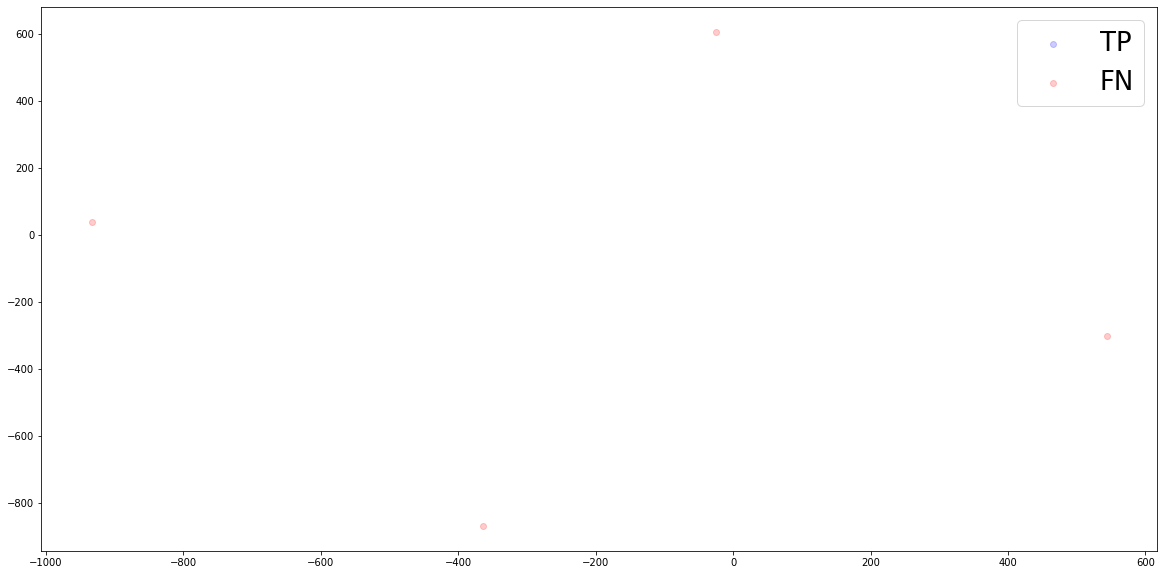




Stats for key: cHS


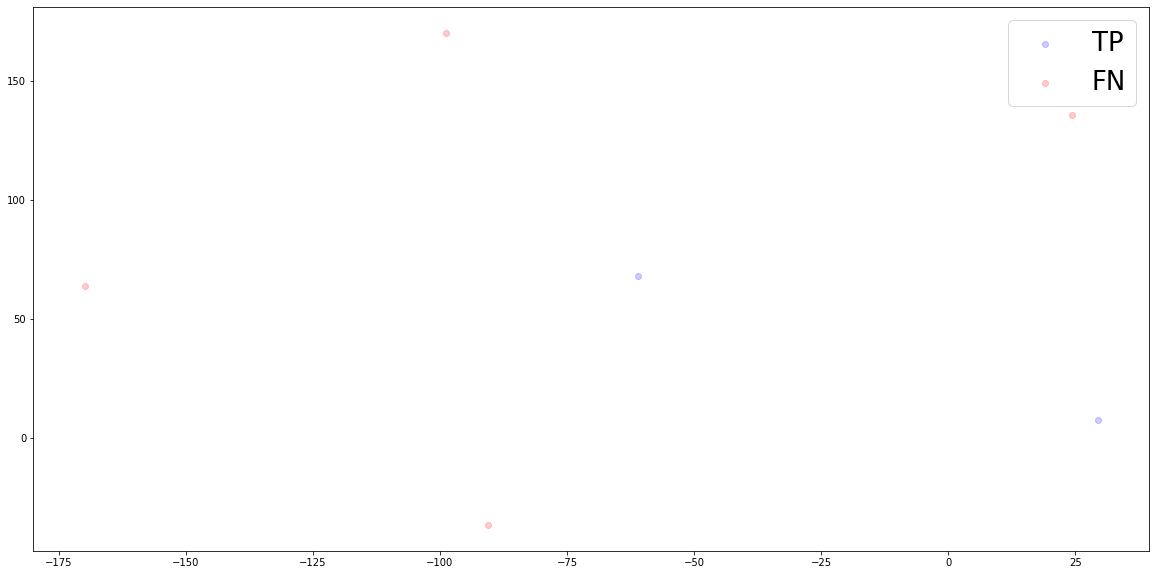




Stats for key: tSS


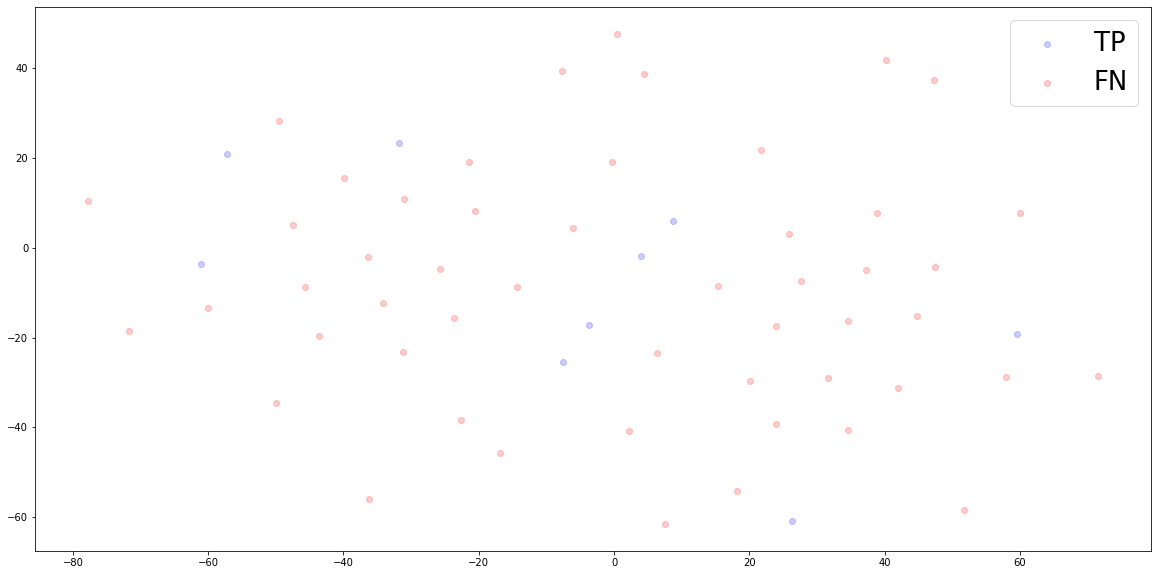




Stats for key: cSW


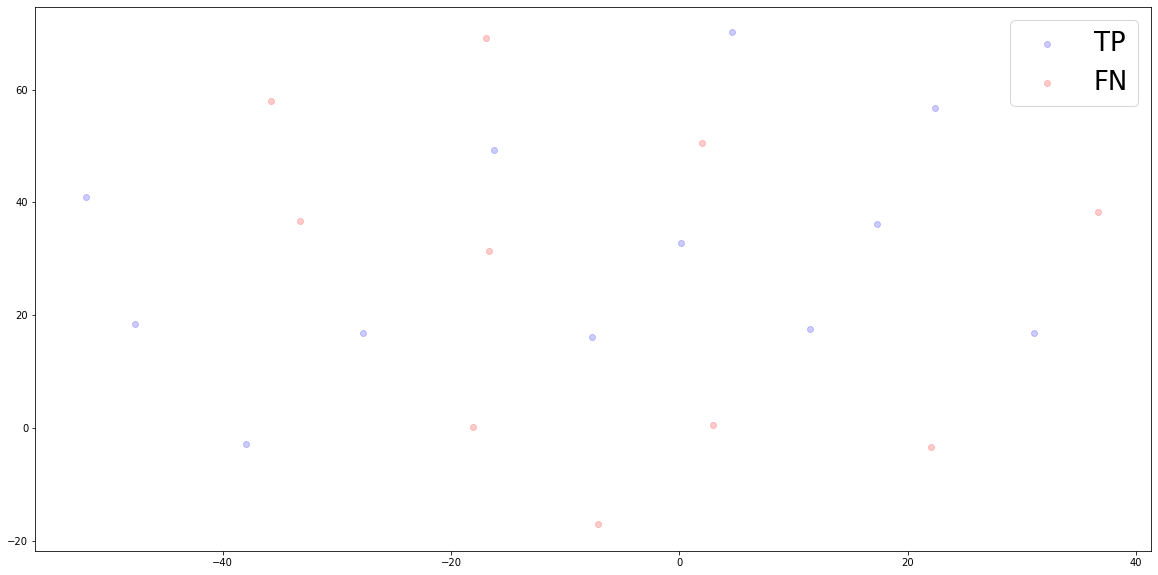




Stats for key: cHW


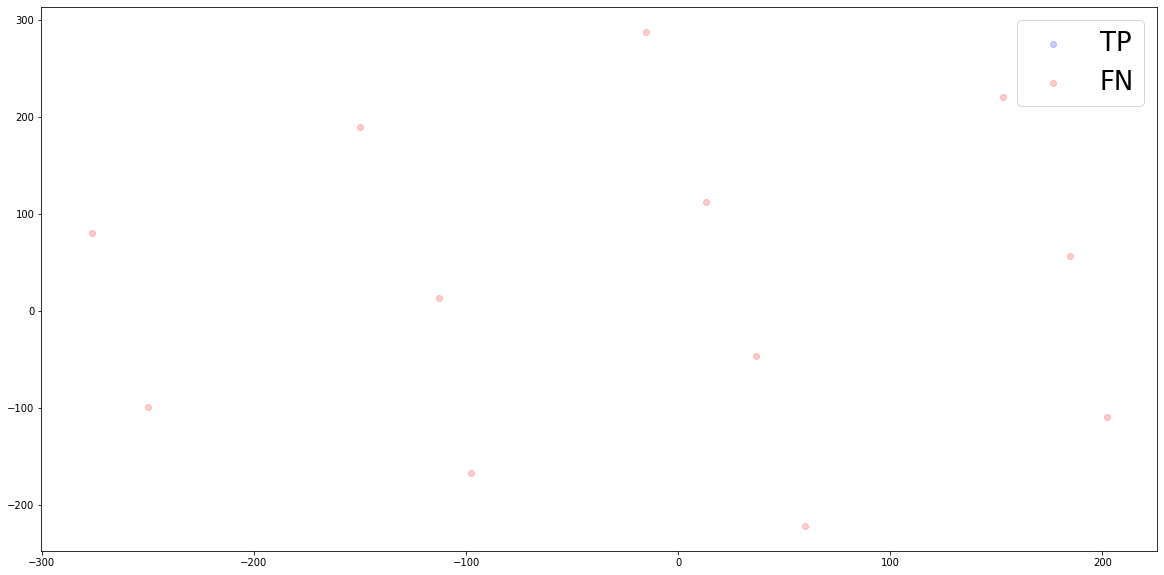




Stats for key: tWW


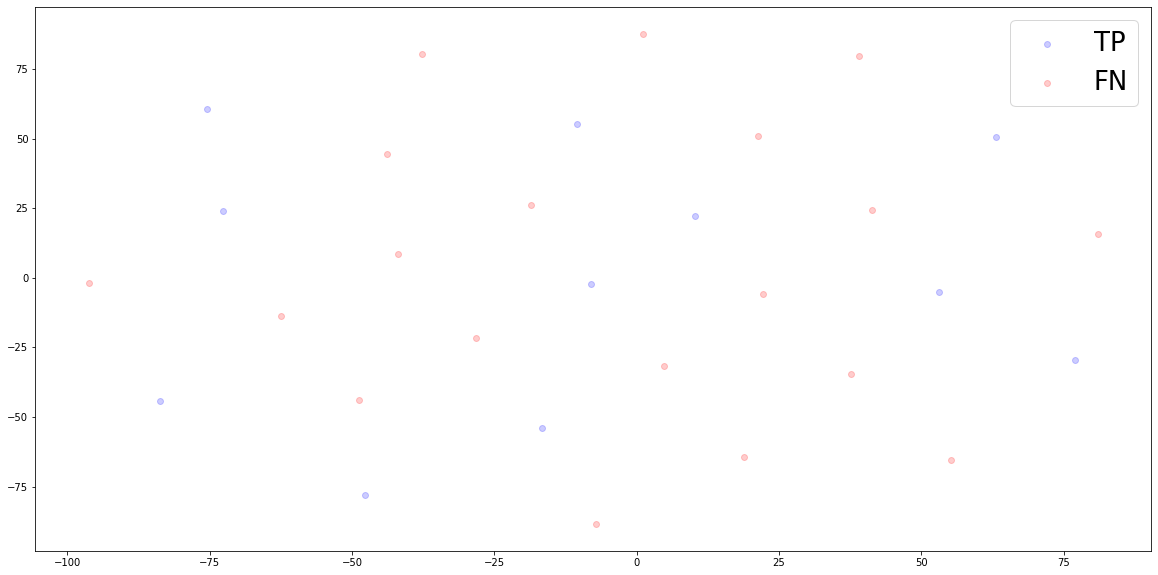




Stats for key: cWW


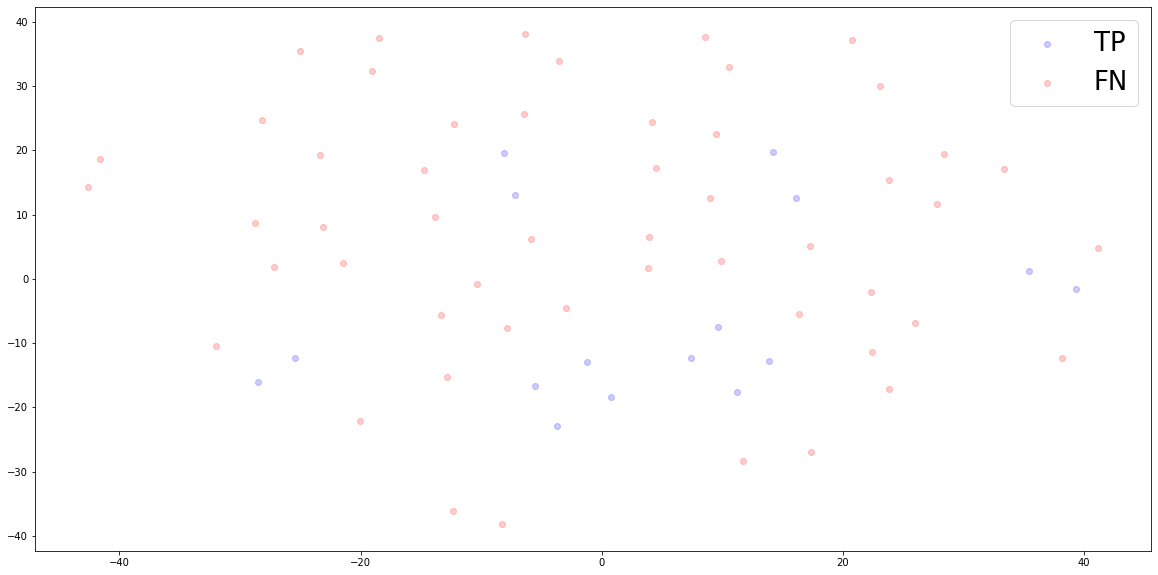




Stats for key: tHW


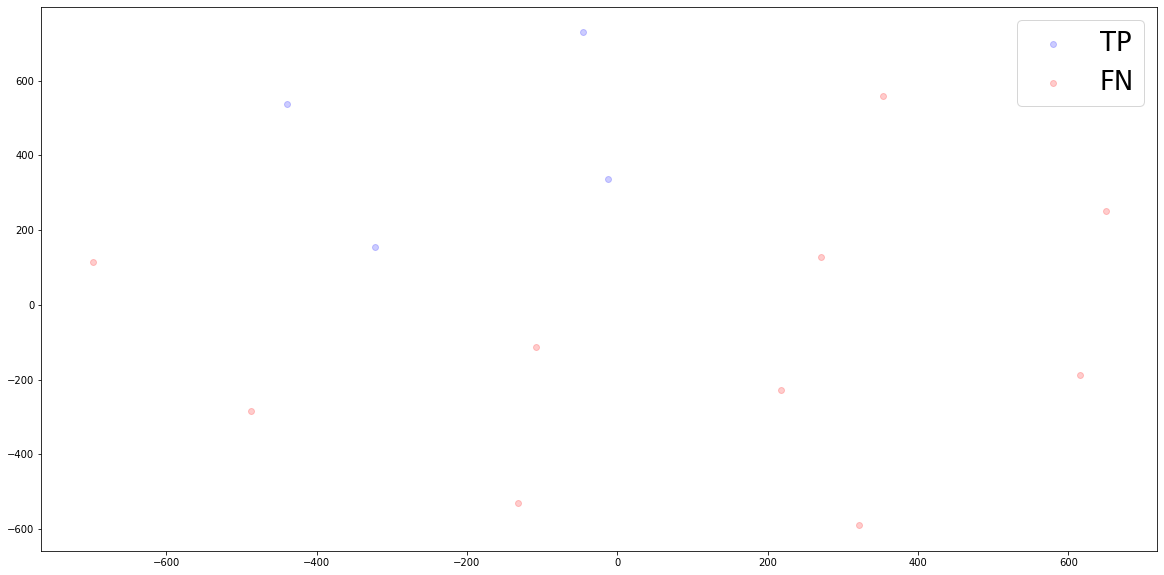

In [19]:
for key in set(keys) - {'NO'}:
    print('\n\n\nStats for key: {}'.format(key))

    key_mask = lw_types == key
    key_tp = tp[key_mask]
    
    key_features = features[key_mask][:, features_index]
    tsne_key_features = key_features[:, key_features.std(axis=0) > 0]
    
    transformed = TSNE().fit_transform((tsne_key_features - tsne_key_features.mean(axis=0)) / \
                                       tsne_key_features.std(axis=0))
    
    plt.figure(figsize=(20, 10))

    plt.scatter(transformed[key_tp, 0], transformed[key_tp, 1], c='b', alpha=.2, label='TP')
    plt.scatter(transformed[~key_tp, 0], transformed[~key_tp, 1], c='r', alpha=.2, label='FN')
    
    plt.legend(fontsize=26)
    plt.show()

Тут tp равномерно распределены по типам по Леонтису, данных мало, так что такой же анализ кластеров, как для SM,  провести не получится.

Построим разрезы TP и FN по типам оснований в парах.

In [20]:
base_types = np.repeat(np.load(os.path.join(DATASET_DIR, 'base.npy')), 2)[mask]

In [23]:
keys = list(set(base_types) - {'NO'})
true_positive_counter = Counter(base_types[tp])
false_negative_counter = Counter(base_types[fn])

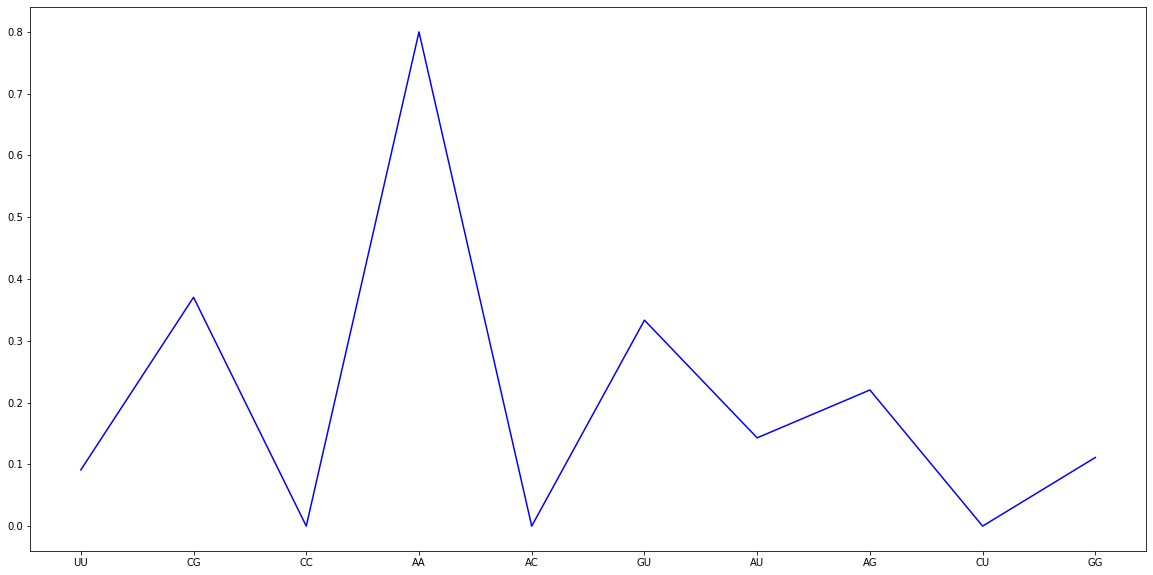

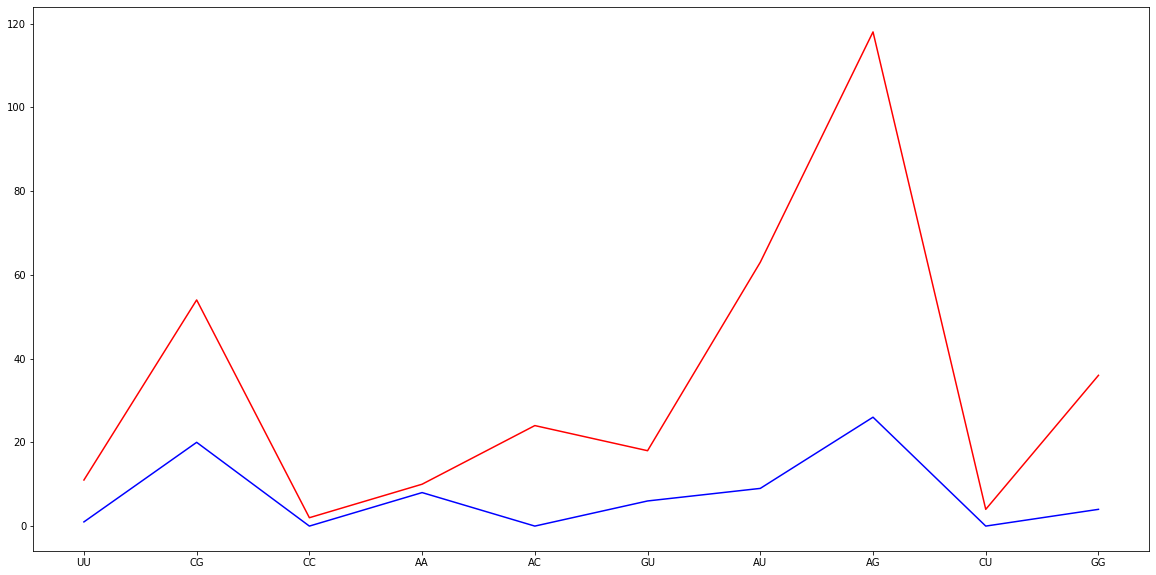

In [24]:
xs = np.arange(len(keys))
true_positive_num = np.array([true_positive_counter[k] for k in keys])
false_negative_num = np.array([false_negative_counter[k] for k in keys])

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, true_positive_num / false_negative_num, c='b')

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, true_positive_num, c='b')
plt.plot(xs, false_negative_num, c='r')